# Allora Forge ML Workflow

This notebook with help you get started submitting inferences to the Allora network and take part in the Forge competition.

## In this notebook you will quickly be able to:

  1. Load training and validation data.
  2. Load a LightGBM model
  3. Train the model
  4. Evaluate the model on validation data (recent 6 months)
  5. Package your predict function into a `.pkl` file
  6. Run your worker node to deliver inferences to Allora's network in real time

## What you will need

  1. **Allora Data API Key** (get your api key here: [https://developer.allora.network/](https://developer.allora.network/).  )
  2. **Allora (testnet) Wallet Mnemonic** (if you don't have a wallet, create one, save the mnemonic.)

# Happy Coding

Let's go.

## Install all necessary packages

In [ ]:
'''
Install all necessary packages
'''

%pip install git+https://github.com/allora-network/allora-forge-ml-workflow.git
%pip install lightgbm scikit-learn pandas numpy matplotlib dill 

'\nInstall all necessary packages\n'

## Imports

The following libraries are required for this workflow:
- `allora_ml_workflow` for interfacing with the Allora Forge ML Workflow.
- `lightgbm` for model training.
- `pandas` and `numpy` for data manipulation.
- `cloudpickle` for serialization.
- `matplotlib` for visualization.
- `time` for timing operations.

These will be imported in the next code cell.

In [1]:
from allora_ml_workflow import AlloraMLWorkflow #Allora Forge
from allora_ml_workflow import get_api_key
import lightgbm as lgb
import pandas as pd
import cloudpickle
import time
import matplotlib.pyplot as plt
import numpy as np

## API KEY
This gives you access to OHLCV (open, high, low, close, volume) candle data through the workflow.

To get your API key, go to [https://developer.allora.network/](https://developer.allora.network/),  
create an account, and generate a new API key.

In [2]:
api_key = get_api_key()

## Initializing the Workflow
### Defining Assets, Input Feature Window, Target

Before training a model, we need to specify how much historical data to use as input features, and how far into the future we want to predict (the target). In this section, we define the parameters that control the *shape* and *amount* of our input features, which are simply normalized historical OHLCV candles.

- **tickers**: The set of tickers for data.
- **hours_needed**: This sets the total length (in hours) of the lookback window, i.e., how much historical context the model will see for each prediction.
- **number_of_input_candles**: This determines how many candles (or chunks) the lookback window is divided into. Each candle summarizes a portion of the lookback window, and together they form the input features.
- **target_length**: This specifies how many hours into the future we want to predict. For the Allora Forge competition, this should match the target horizon required by the challenge.

For example:

- Setting `hours_needed = 72` and `number_of_input_candles = 3` gives **3 daily candles** as input (each candle covers 24 hours).
- Setting `hours_needed = 24` and `number_of_input_candles = 24` gives **24 hourly candles** as input (each candle covers 1 hour).

We'll visualize the resulting features a few cells below, so you can see exactly what the model will receive as input.

In [12]:
ticker = "btcusd" #eg btcusd, ethusd, solusd
tickers = [ticker] # for just btc: tickers=['btc']
hours_needed = 5*24             # Number of historical hours for feature lookback window
number_of_input_candles = 12    # Number of candles for input features
target_length = 24            # Number of hours into the future for target (depends on forge competition)

# Instantiate the workflow
workflow = AlloraMLWorkflow(
    data_api_key=api_key,
    tickers=tickers,
    hours_needed=hours_needed,
    number_of_input_candles=number_of_input_candles,
    target_length=target_length
)

## Getting Data
### Training, Validation, and Test Data for Supervised Learning

The `get_train_validation_test_data` function splits your historical data into three consecutive time periods: **training**, **validation**, and **test**. This is a standard approach in supervised machine learning to ensure that your model is evaluated on data it has never seen during training.

### Arguments:
- **`from_month`**: The starting month (YYYY-MM) for the entire dataset. The earliest available is `"2020-01"`.
- **`validation_months`**: Number of months to reserve for the validation set (used for tuning hyperparameters and early stopping).
- **`test_months`**: Number of months to reserve for the test set (used for final evaluation).

### Data Splits:
The data is split chronologically:
1. **Training Set**: Includes all data from `from_month` up to the start of the validation period.
2. **Validation Set**: Immediately follows the training set, with an embargo (gap) equal to the prediction target length (e.g., 24 hours) to prevent data leakage.
3. **Test Set**: Follows the validation set, again separated by an embargo of the same length.

### How Long Does it Take?
Loading data should only take a few minutes, and versions of data are cached for quicker load times in the future. 
- Force a re-download of fresh data with `force_redownload=True`.

### Visual Schematic:
For a 24-hour target:

| **Training Set** | → **24 hr** → | **Validation Set** | → **24 hr** → | **Test Set** |


In [13]:
# Get training, validation, and test data
X_train, y_train, X_val, y_val, X_test, y_test = workflow.get_train_validation_test_data(
    from_month="2023-01",
    validation_months=3,
    test_months=3,
    force_redownload=False  # Set to True to force re-download of fresh data
)

# Example: Check the shapes of the datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Processing 5-minute bars for btcusd
Computing target
Extracting features
Saving data to data_btcusd_2023-01_val3_test3_candles12.pkl
Training set: (215348, 79) (215348,)
Validation set: (22592, 79) (22592,)
Test set: (26208, 79) (26208,)


## Visualizing Data Time Spans

The next cell visualizes the time spans covered by the training, validation, and test datasets. This helps to ensure that the data splits are correctly separated in time and that there is no data leakage between them.

Training set: 2023-01-05 23:55:00+00:00 to 2025-02-17 18:25:00+00:00
Validation set: 2025-02-18 18:30:00+00:00 to 2025-05-18 18:25:00+00:00
Test set: 2025-05-19 18:30:00+00:00 to 2025-08-18 18:25:00+00:00


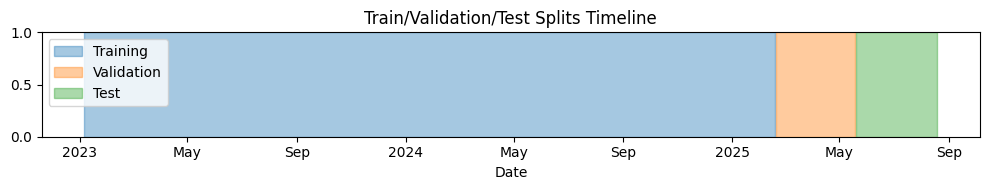

In [14]:
# Print start and end dates for each split
def print_split_dates(X, name):
    if isinstance(X.index, pd.MultiIndex):
        dates = X.index.get_level_values(0)
    else:
        dates = X.index
    print(f"{name} set: {dates.min()} to {dates.max()}")

print_split_dates(X_train, "Training")
print_split_dates(X_val, "Validation")
print_split_dates(X_test, "Test")

# Visualize the splits on a timeline
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 2))

def plot_span(X, color, label):
    if isinstance(X.index, pd.MultiIndex):
        dates = X.index.get_level_values(0)
    else:
        dates = X.index
    ax.axvspan(dates.min(), dates.max(), color=color, alpha=0.4, label=label)

plot_span(X_train, 'tab:blue', 'Training')
plot_span(X_val, 'tab:orange', 'Validation')
plot_span(X_test, 'tab:green', 'Test')

ax.legend(loc='upper left')
ax.set_title("Train/Validation/Test Splits Timeline")
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.tight_layout()
plt.show()

## Visualizing Features and Historical Price Process

In the next cell, we select a single row of data and visualize the features associated with it. These features represent the normalized historical OHLCV (open, high, low, close, volume) candles leading up to the selected time index. 

To provide additional context, we overlay the historical price process during the same time period. This allows us to visually compare the input features with the actual price movements of the asset, offering insights into the relationship between the features and the price process.


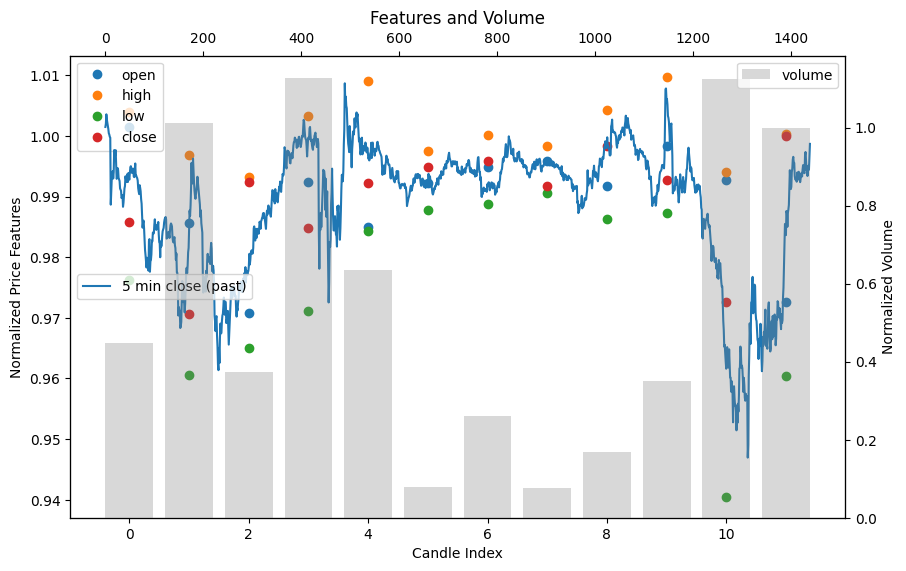

In [15]:
this_data = X_train.loc[(slice(None), 'btcusd'), :]

data_idx = -10000  # which data point to visualize

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot features based on data_idx
ax1.plot([this_data.iloc[data_idx][f"feature_open_{i}"] for i in range(number_of_input_candles)], 'o', label="open")
ax1.plot([this_data.iloc[data_idx][f"feature_high_{i}"] for i in range(number_of_input_candles)], 'o', label="high")
ax1.plot([this_data.iloc[data_idx][f"feature_low_{i}"] for i in range(number_of_input_candles)], 'o', label="low")
ax1.plot([this_data.iloc[data_idx][f"feature_close_{i}"] for i in range(number_of_input_candles)], 'o', label="close")
ax1.set_xlabel("Candle Index")
ax1.set_ylabel("Normalized Price Features")
ax1.legend(loc="upper left")

# Plot past price process based on data_idx
plt.twiny()
plt.plot(
    (this_data.iloc[data_idx - (hours_needed * 12):data_idx]['close'].values) / this_data.iloc[data_idx]['close'],
    label="5 min close (past)"
)
plt.legend(loc='center left')

# Plot volume as a bar chart with independent y-axis
ax2 = ax1.twinx()
ax2.bar(range(number_of_input_candles), 
    [this_data.iloc[data_idx][f"feature_volume_{i}"] for i in range(number_of_input_candles)], 
    alpha=0.3, color='gray', label="volume")
ax2.set_ylabel("Normalized Volume")
ax2.legend(loc="upper right")

plt.title("Features and Volume")
plt.show()


## Visualizing the Target

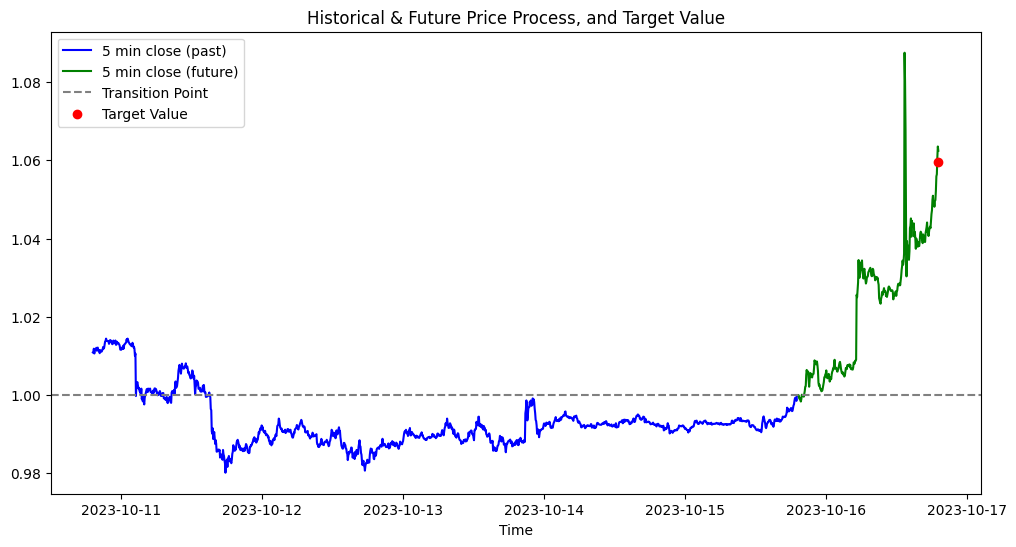

In [16]:
this_data = X_train.loc[(slice(None), 'btcusd'), :]

data_idx = 80000  # which data point to visualize

fig, ax = plt.subplots(figsize=(12, 6))

# Historical price process (normalized so last value is 1)
hist_prices = this_data.iloc[data_idx - (hours_needed * 12):data_idx]['close']
hist_times = this_data.iloc[data_idx - (hours_needed * 12):data_idx].index.get_level_values(0)
if not hist_prices.empty:
    hist_norm = hist_prices / hist_prices.iloc[-1]
else:
    hist_norm = hist_prices

# Future price process (normalized so first value is 1)
selected_time = this_data.iloc[data_idx].name[0] if isinstance(this_data.index, pd.MultiIndex) else this_data.index[data_idx]
future_time = selected_time + pd.Timedelta(hours=target_length)
future_prices = this_data['close']
future_mask = (future_prices.index.get_level_values(0) > selected_time) & \
              (future_prices.index.get_level_values(0) <= future_time)
future_price_series = future_prices[future_mask]
if not future_price_series.empty:
    future_norm = future_price_series / future_price_series.iloc[0]
else:
    future_norm = future_price_series

# Plot historical and future price process on the same axis
ax.plot(hist_times, hist_norm.values, label="5 min close (past)", color='blue')
ax.plot(future_price_series.index.get_level_values(0), future_norm.values, label="5 min close (future)", color='green')
ax.axhline(1, color='gray', linestyle='--', label='Transition Point')
ax.set_xlabel("Time")
ax.legend(loc='center left')

# Overlay target value
target_value = y_train.loc[(selected_time, 'btcusd')] if isinstance(y_train.index, pd.MultiIndex) else y_train[selected_time]
ax.scatter([future_time], [1 + target_value], color='red', label='Target Value', zorder=5)
ax.legend(loc='upper left')

plt.title("Historical & Future Price Process, and Target Value")
plt.show()


## "Hello World!" ML Model

- This notebook demonstrates a simple **LightGBM model** that predicts the future price of an asset based on its past price process, as represented by the features.
- The **validation set** is used to:
    - Tune the model.
    - Perform **early stopping**, which helps prevent overfitting.
- The **test set** is used to evaluate the model's performance.

### Workflow Summary:
1. The model is trained on the **training set**.
2. Early stopping is applied using the **validation set** to determine the best iteration.
3. The model is retrained on the combined **training and validation data** using the best iteration found during training.
4. Finally, the model is evaluated on the **test set**.

---

### Future Directions:
- This is just one example of a modeling workflow. 
- This is where a lot of **modeling magic** can happen:
    - Experiment with swapping in new techniques and models.
    - Try different feature engineering strategies.
    - Explore alternative evaluation metrics.
- Stay tuned! More notebooks will be available in the future with **different ideas and approaches** to inspire your modeling journey.

In [44]:
#define feature columns and ML model
feature_cols = [f for f in list(X_train) if 'feature' in f]

#define hyperparameters for the LightGBM model
learning_rate = 0.1
max_depth = 5
num_leaves = 16

# Initialize LightGBM model with hyperparameters
model = lgb.LGBMRegressor(
    n_estimators=2000,  # Set a high number of estimators for early stopping
    learning_rate=learning_rate,
    max_depth=max_depth,
    num_leaves=num_leaves
)

# Define custom evaluation metric for correlation
def corr_eval_metric(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    # LightGBM expects: (eval_name, eval_result, is_higher_better)
    return 'corr', corr, True

# Fit model with early stopping
model.fit(
    X_train[feature_cols], y_train,
    # eval_set=[(X_val[feature_cols], y_val)],
    # eval_metric=corr_eval_metric,
    # callbacks=[
    #     lgb.early_stopping(stopping_rounds=100, verbose=True)
    # ]
)
# best_iteration = model.best_iteration_

# #retrain the model to best iteration on train + validation data
# model = lgb.LGBMRegressor(
#     n_estimators=best_iteration,  # Use the optimal number of trees
#     learning_rate=learning_rate,
#     max_depth=max_depth,
#     num_leaves=num_leaves
# )
model.fit(
    pd.concat([X_train[feature_cols], X_val[feature_cols]]), 
    pd.concat([y_train, y_val])
)
# Evaluate
#  on the test data
test_preds = model.predict(X_test[feature_cols])
test_preds = pd.Series(test_preds, index=X_test.index)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 215348, number of used features: 70
[LightGBM] [Info] Start training from score 0.002240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 237940, number of used features: 70
[LightGBM] [Info] Start training from score 0.002246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

In [ ]:
# Install the allorad CLI tool (required for wallet management and network interaction)
!curl -sSL https://raw.githubusercontent.com/allora-network/allora-chain/main/install.sh | bash -s -- v0.8.0

# After installation, you can verify with:
!allorad version

## The Workflow has a built-in method to evaluate the test data predictions.

In [42]:
#show test metrics
metrics = workflow.evaluate_test_data(test_preds)
print(metrics)

#check directional accuracy for only predictions over a certain threshold, like 0.01
threshold = .02
good_data_index = np.abs(test_preds) > threshold
good_preds = test_preds[good_data_index]
good_trues = y_test[good_data_index]
da = np.mean(np.sign(good_preds) == np.sign(good_trues))
print(da)

{'correlation': 0.03210627532121019, 'directional_accuracy': 0.5009157509157509}
0.6301605504587156


## Retraining for live deployment
The model is finally re-trained on the entire dataset, including the test data,
before it is packaged into a pickled function for live predictions.

The `workflow.get_live_features` function creates a version of the features based on the most up-to-date live data, in exactly the same way that the historical data features were created, ensuring the model is getting coherent live data.

In [31]:
model.fit(
    pd.concat([X_train[feature_cols], X_val[feature_cols], X_test[feature_cols]]), 
    pd.concat([y_train, y_val, y_test])
)

# Final predict function
def predict() -> pd.Series:
    live_features = workflow.get_live_features("btcusd")
    preds = model.predict(live_features)
    return float( np.array( preds ) [0] )

# Pickle the function
with open("predict.pkl", "wb") as f:
    cloudpickle.dump(predict, f)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 264148, number of used features: 70
[LightGBM] [Info] Start training from score 0.002122


## Test Live Predictions

This function simulates a live prediction scenario by loading the pickled function,
calling it, and printing the prediction time and result.

In [32]:
# Load the pickled predict function
with open("predict.pkl", "rb") as f:
    predict_fn = cloudpickle.load(f)

# Call the function and get predictions
tic = time.time()
prediction = predict_fn()
toc = time.time()

print("predict time: ", (toc - tic) )
print("prediction: ", prediction )


Live Mode Bars:                                       open           high            low  \
date                                                                     
2025-08-19 18:14:00+00:00  113459.594978  113476.244529  113310.799429   
2025-08-19 18:19:00+00:00  113468.518112  113483.624232  113277.481736   
2025-08-19 18:24:00+00:00  113314.581673  113412.807524  113301.781235   
2025-08-19 18:29:00+00:00  113291.895542  113293.000296  113202.922829   
2025-08-19 18:34:00+00:00  113237.516463  113261.315736  113107.508033   

                                   close     volume  trades_done  
date                                                              
2025-08-19 18:14:00+00:00  113468.491206  47.461966         2256  
2025-08-19 18:19:00+00:00  113327.570195  46.844977         2478  
2025-08-19 18:24:00+00:00  113342.340622  35.519684         2129  
2025-08-19 18:29:00+00:00  113219.708149  47.687015         2411  
2025-08-19 18:34:00+00:00  113123.249311  46.095746         2

## Install Allora's Python Worker from Python SDK (development version)

This cell installs the worker code on your local computer, and works on Colab. It requires installing and using a protobuf compiler.

In the future, installation will be easier, with pre-compiled versions installed directly from pip.

In [42]:
!apt-get install -y libprotobuf-dev
!test -f /usr/include/google/protobuf/descriptor.proto && echo "descriptor.proto present ✅"

# clone the right branch
%cd /content
!git clone -b spook/cosmos-protobuf-client https://github.com/allora-network/allora-sdk-py.git
%cd allora-sdk-py

# rerun your build
%cd /content/allora-sdk-py
!make dev

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
descriptor.proto present ✅
descriptor.proto present ✅
[Errno 2] No such file or directory: '/content'
/home/jefferythewind/Projects/Allora/ML Workflow/notebooks/allora-sdk-py
[Errno 2] No such file or directory: '/content'
/home/jefferythewind/Projects/Allora/ML Workflow/notebooks/allora-sdk-py
Cloning into 'allora-sdk-py'...
Cloning into 'allora-sdk-py'...
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (476/476), done.
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (476/476), done.
remote: Compressing objects: 100% (237/237), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 476 (delta 163), reused 444 (delta 136), pack-reused 0 (from 0)
Receiving objects: 100% (476/476), 616.49 KiB | 7.25 MiB/s, done.
Resolving deltas: 100% (163/163), done.
re

## 🚀 Run Your Worker Node

This step will create a file, `run_worker.py`, which loads your pickled prediction function and submits predictions to the Allora network at the required intervals.

In [34]:
topic_id = 61 #BTC 24 Hour Log Return

file_text = '''
import asyncio
import logging
from allora_sdk.protobuf_client.tx_manager import FeeTier
from allora_sdk.worker import AlloraWorker
from allora_sdk.utils.get_mnemonic import get_mnemonic
import cloudpickle

async def run_worker(worker_id: int, topic_id: int, predict_fn: callable):
    worker = AlloraWorker(
        topic_id=topic_id,
        predict_fn=predict_fn,
        fee_tier=FeeTier.PRIORITY,
        mnemonic=get_mnemonic(),
    )

    async for result in worker.run():
        if isinstance(result, Exception):
            # print(f"error: {str(result)}")
            continue
        print(f"Worker {worker_id} (topic {topic_id}): {result.prediction}")

async def main():
    with open("predict.pkl", "rb") as f:
      predict_fn = cloudpickle.load(f)
    task1 = asyncio.create_task(run_worker(1, %s, predict_fn))
    await asyncio.gather(task1)

if __name__ == "__main__":
    asyncio.run(main())
''' % (topic_id)

#write text to run_worker.py
with open("run_worker.py", "w", encoding="utf-8") as f:
    f.write(file_text)

#run run_worker.py from command line with python run_worker.py
#python run_worker.py

### How to Run Your Worker

**Option 1: From the Command Line**

```bash
python run_worker.py
```

**Option 2: From a Jupyter Notebook Cell**

```python
!python run_worker.py
```

> **Note:** Running from the notebook may have limitations with interactive prompts, depending on your environment.

---

### 🔑 Wallet Mnemonic Prompt

- When you start your worker, you will be prompted for your Allora wallet mnemonic.
- Enter your mnemonic securely when prompted.

---

Once started, your worker will begin submitting live predictions to the Allora network. You can stop the worker at any time by interrupting the process (Ctrl+C in terminal or "Interrupt" in Jupyter).